# vanilla RNN 

build upon backToTheTrap

### Environment setup

##### pip install

In [2]:
!pip install tensorflow==2.1.0

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


In [3]:
!pip install numpy==1.19.5

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


### Back To The Trap



In [4]:
import sys
print("Python version")
print (sys.version)
print("Version info.")
print (sys.version_info)

Python version
3.7.10 (default, Jun  4 2021, 14:48:32) 
[GCC 7.5.0]
Version info.
sys.version_info(major=3, minor=7, micro=10, releaselevel='final', serial=0)


In [5]:
import numpy
numpy.version.version

'1.19.5'

In [6]:
import tensorflow as tf
print(tf.__version__)

2.1.0


### Goal
The main goal here is to __predict__ the next __BID CLOSE__.<br>
"*How much they will be paying for this active at the end of the next minute*"

##### In this notebook specifically.. we trying to set some benchmarks to LSTM
We gon run some predictions with vanilla RNN to use its results as a benchmarck to LSTM model

### 1st Step

# Data Wrangling

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from datetime import datetime

##  Data Ingestion

All data was extracted from Dukascopy Swiss Bank Group.
Dukascopy is a regulated bank that is authorised in two tier-1 jurisdictions (high trust), making it a safe broker (low-risk) for forex and CFDs trading. https://www.dukascopy.com/plugins/fxMarketWatch/?historical_data

In [8]:
bucket='bnr-bucket-01'
file_key = 'EURUSD_Candlestick_1_M_BID_06.03.2021-11.03.2021.csv'

s3uri = 's3://{}/{}'.format(bucket, file_key)

data = pd.read_csv(s3uri, header = 0)

AttributeError: 'AioClientCreator' object has no attribute '_register_lazy_block_unknown_fips_pseudo_regions'

In [ ]:
data

## Data Transformations

* Dropping undesireble columns
* Converting datatypes
* Defining index

In [12]:
data=data.drop(['Open', 'High', 'Low', 'Volume'], axis='columns', inplace=False)

In [13]:
def convertToDatetime(s):
    match = re.search(r'\d{2}.\d{2}.\d{4} \d{2}:\d{2}', s)
    s_substring = match.group()

    # Create date object in given time format yyyy-mm-dd
    s_datetime = datetime.strptime(s_substring, '%d.%m.%Y %H:%M')

    return s_datetime

data['Gmt time'] = data["Gmt time"].apply(lambda x: convertToDatetime(x))
data = data.rename(columns = {'Gmt time': 'datetime','Close': 'bidclose'}, inplace = False)

In [14]:
data = data.set_index('datetime')

In [15]:
data

,bidclose
datetime,
2021-03-07 00:00:00,1.19128
2021-03-07 00:01:00,1.19128
2021-03-07 00:02:00,1.19128
2021-03-07 00:03:00,1.19128
2021-03-07 00:04:00,1.19128
...,...
2021-03-12 23:55:00,1.19476
2021-03-12 23:56:00,1.19476
2021-03-12 23:57:00,1.19476


## Data Cleaning 

"*The FX market for the week begins at __9PM/10PM__ GMT on Sunday and closes at __9PM/10PM__ on Friday. Traders should be aware of the market timings in GMT, the DST shifts and their own timezone, in relation to the GMT, for them to fully grasp the forex market hours.*" https://www.fxempire.com/education/article/forex-trading-market-hours-408380

In [16]:
data = data.loc["2021-03-07 22:00:00":"2021-03-12 21:59:00"]

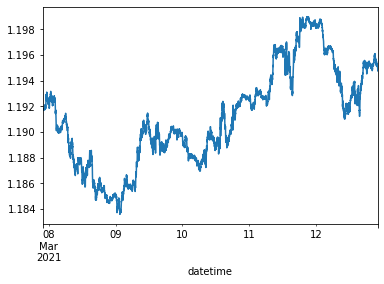

In [17]:
data['bidclose'].plot()

### 2st Step

# Data Preparation (MLP Model)

In [18]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import numpy

## Create new Dataframe to preserve original data

In [19]:
df=data

## Splitting Dataset
Splitting dataset into train and test split
* train_data = first 96 hours (4 days) 
* test_data = last 24 hours

In [20]:
training_size=int(len(df)*0.8)
test_size=len(df)-training_size
train_data, test_data=df.iloc[0:training_size,:], df.iloc[training_size:len(df),:1]

print("train_data size:"+str(len(train_data)))
print("test_test size:"+str(len(test_data)))

train_data size:5760
test_test size:1440


In [21]:
#BACKUP of slipts in UnNormalizedForm
train_data_unf = train_data
test_data_unf = test_data

## Normalize Data

__LSTM__ are sensitive to the scale of the data. <br>
So we need to apply MinMax scaler.<br>
<br>

Not only do you need normalisation on test data, but you should apply the exact same scaling as for your training data.<br>
```python
scaler = StandardScaler()
train_X = scaler.fit_transform( train_X )
test_X = scaler.transform( test_X )
```
(https://datascience.stackexchange.com/questions/27615/should-we-apply-normalization-to-test-data-as-well) 


In [22]:
scaler=MinMaxScaler(feature_range=(0,1))
train_data=scaler.fit_transform(np.array(train_data).reshape(-1,1))

In [23]:
train_data

array([[0.53116883],
       [0.53181818],
       [0.53311688],
       ...,
       [0.96493506],
       [0.96883117],
       [0.96493506]])

In [24]:
test_data=scaler.transform(np.array(test_data).reshape(-1,1))

In [25]:
test_data

array([[0.93571429],
       [0.94805195],
       [0.95714286],
       ...,
       [0.76168831],
       [0.74805195],
       [0.72597403]])

## Create Matrix Dataset
Create x_inputs and y_outputs from (train and test dataset) to be ingest by LSTM Model<br>

Convert an array of values into a dataset matrix

In [26]:
def create_dataset(dataset, time_step=1):
    dataX=[]
    dataY=[]
    currentX=[]
    
    for i in range(len(dataset)):
        if(i>=time_step):
            a=dataset[i-time_step:i,0]
            dataX.append(a)
            dataY.append(dataset[i,0])
    
    return numpy.array(dataX), numpy.array(dataY)

In [27]:
a=[0,1,2,3,4,5,6]
a=np.array(a).reshape(-1,1)

In [28]:
##Create x_inputs and y_outputs from (train and test dataset) to be ingest by LSTM Model
##Following this fashion
##Example:

a=[0,1,2,3,4,5,6]
a=np.array(a).reshape(-1,1)
time_step=3
create_dataset(a,time_step)

(array([[0, 1, 2],
        [1, 2, 3],
        [2, 3, 4],
        [3, 4, 5]]),
 array([3, 4, 5, 6]))

In [29]:
time_step = 100
x_train, y_train = create_dataset(train_data, time_step)
x_test, y_test = create_dataset(test_data, time_step)

In [30]:
print("x_train.shape: "+str(x_train.shape))
print("y_train.shape: "+str(y_train.shape))

print("x_test.shape: "+str(x_test.shape))
print("y_test.shape: "+str(y_test.shape))

x_train.shape: (5660, 100)
y_train.shape: (5660,)
x_test.shape: (1340, 100)
y_test.shape: (1340,)


## Reshape [sample, time_steps, features]
Reshape input to be [sample, time_steps, features] witch is __required for LSTM__

In [31]:
x_train= x_train.reshape(x_train.shape[0],x_train.shape[1],1)
x_test=x_test.reshape(x_test.shape[0],x_test.shape[1],1)

## Create validation dataset

_"Suppose that we would like to estimate the test error associated with fitting a particular statistical learning method on a set of observations. The __validation set__ approach […] is a very simple strategy for this task. It involves randomly __dividing the available set of observations into two parts__, a training set and a validation set or hold-out set. The model is fit on the training set, and the fitted model is used to predict the responses for the observations in the validation set. The resulting validation set error rate — typically assessed using MSE in the case of a quantitative response—provides an estimate of the test error rate."_ — Gareth James

– __Training set__: A set of examples used for learning, that is to fit the parameters of the classifier.

– __Validation set__: A set of examples used to tune the parameters of a classifier, for example to choose the number of hidden units in a neural network.

– __Test set__: A set of examples used only to assess the performance of a fully-specified classifier.

In [32]:
x_fullTrain = x_train
y_fullTrain = y_train
x_val = x_train[-1000:]
y_val = y_train[-1000:]
x_train = x_train[:-1000]
y_train = y_train[:-1000]

### 3st Step

# Long Short Term Memory

In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import SimpleRNN

In [35]:
import tensorflow as tf

In [36]:
print(tf.__version__)

2.1.0


## Create the Stacked LSTM model

Stacked LSTM
```
model = Sequential()
model.add(LSTM(15,return_sequences=True, input_shape=(x_train.shape[1],x_train.shape[2])))
model.add(LSTM(15,return_sequences=True))
model.add(LSTM(15))
model.add(Dense(x_train.shape[2]))
model.compile(loss='mean_squared_error',optimizer='adam')
```

SimpleRNN
```
model = Sequential()
model.add(SimpleRNN(1, input_shape=(x_train.shape[1],x_train.shape[2])))
model.compile(loss='mean_squared_error',optimizer='adam')
```

Stacked RNN

In [38]:
model = Sequential()
model.add(SimpleRNN(15, return_sequences=True, input_shape=(100,x_train.shape[2])))
model.add(SimpleRNN(15,return_sequences=True))
model.add(SimpleRNN(15,return_sequences=True))
model.add(SimpleRNN(x_train.shape[2]))
model.compile(loss='mean_squared_error',optimizer='adam')

#obs: input_shape=(length of the sequences, n_ofFeatures)
#     batch_input_shape =(nOf_InputSequences, length of the sequences, n_ofFeatures)
#ex:  input_shape=(100,1)
#     batch_input_shape=(4660,100,1)
#formally: batch_input_shape = (batch_size, timesteps, input_dim)

In [39]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_4 (SimpleRNN)     (None, 100, 15)           255       
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 100, 15)           465       
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, 100, 15)           465       
_________________________________________________________________
simple_rnn_7 (SimpleRNN)     (None, 1)                 17        
Total params: 1,202
Trainable params: 1,202
Non-trainable params: 0
_________________________________________________________________


## Train the Stacked LSTM model

__BATCH:__ The __batch__ size is a hyperparameter that defines the number of samples to work through before updating the internal model parameters.<br>
__EPOCH:__ The number of __epochs__ is a hyperparameter that defines the number times that the learning algorithm will work through the entire training dataset.

* __Batch Gradient Descent.__ Batch Size = Size of Training Set
* __Stochastic Gradient Descent.__ Batch Size = 1
* __Mini-Batch Gradient Descent.__ 1 < Batch Size < Size of Training Set

In [40]:
#stacked #vanilla RNN
history = model.fit(x_train,y_train,validation_split=0.2,epochs=50,batch_size=64,verbose=1)

Train on 3728 samples, validate on 932 samples
Epoch 1/50
3728/3728 [==============================] - 9s 2ms/sample - loss: 0.0071 - val_loss: 0.0058
Epoch 2/50
3728/3728 [==============================] - 5s 1ms/sample - loss: 0.0011 - val_loss: 0.0022
Epoch 3/50
3728/3728 [==============================] - 5s 1ms/sample - loss: 6.0866e-04 - val_loss: 0.0014
Epoch 4/50
3728/3728 [==============================] - 5s 1ms/sample - loss: 4.1602e-04 - val_loss: 9.5811e-04
Epoch 5/50
3728/3728 [==============================] - 5s 1ms/sample - loss: 3.6220e-04 - val_loss: 8.6136e-04
Epoch 6/50
3728/3728 [==============================] - 5s 1ms/sample - loss: 3.2177e-04 - val_loss: 7.5440e-04
Epoch 7/50
3728/3728 [==============================] - 5s 1ms/sample - loss: 2.9877e-04 - val_loss: 3.9525e-04
Epoch 8/50
3728/3728 [==============================] - 5s 1ms/sample - loss: 2.6213e-04 - val_loss: 5.6400e-04
Epoch 9/50
3728/3728 [==============================] - 5s 1ms/sample - loss:

## Learning Curve

These plots can help to diagnose whether the model has over learned, under learned, or is suitably fit to the training dataset.
https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/

#### OBS:
Note that what was printed above as "loss", actually refers to cost_function
<br>
<br>
* One __EPOCH__ is when an ENTIRE dataset is passed forward and backward through the neural network only ONCE.<br>
* The __COST_FUNCTION__ (Results from whole trainining data_set samples analysis)<br>
It is a single value that measures how bad was the model at particular EPOCH, by calculating the mean between all LOSS_FUNCTIONS.<br>
* The __LOSS_FUNCTION__ (Results from one single training sample analysis)<br>
It is the cost of a single training example. Difference between values predicted and the actuals outputs expected. (usually: Mean Squared Error)
* The __OPTIMIZERS__<br>
Once we have the COST_FUNCTION of an Epoch, we can apply __OPTIMIZERS__ in order to reduce its value, and therefore find a minimal COST<br>

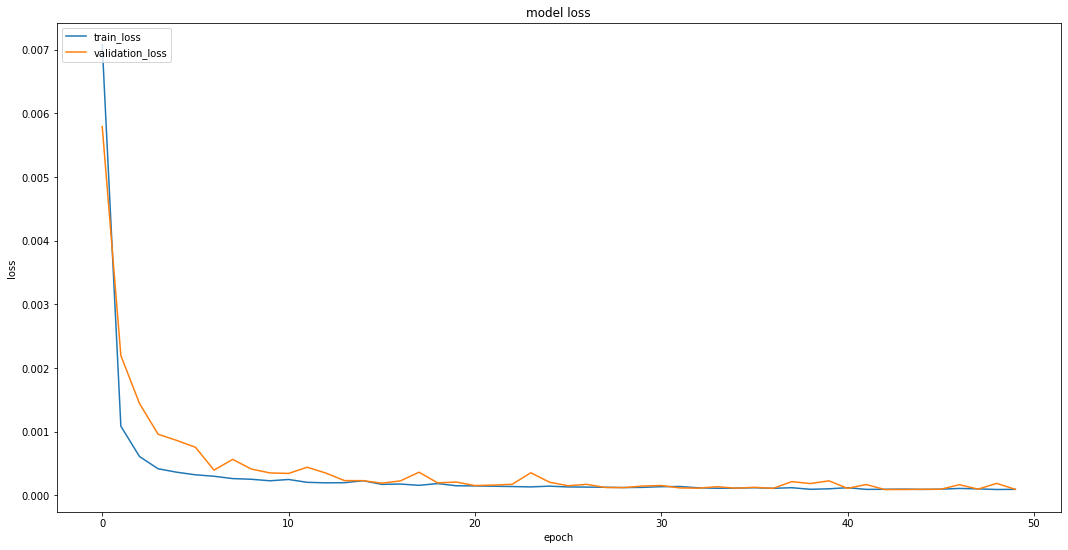

In [41]:
plt.figure(figsize = (18,9))
##plt.xlim(3500,4500)
##plt.ylim(0,0.0002)


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'validation_loss'], loc='upper left')

plt.show()

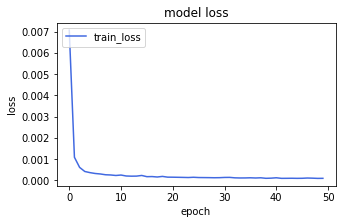

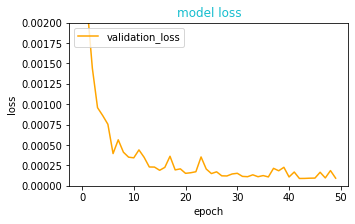

In [42]:
plt.figure(figsize = (5,3))
##plt.xlim(3500,4500)
##plt.ylim(0,0.0003)


plt.plot(history.history['loss'],color='royalblue')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss'], loc='upper left')

plt.show()

plt.figure(figsize = (5,3))
#plt.xlim(3500,4500)
plt.ylim(0,0.002)

plt.plot(history.history['val_loss'],color='orange')
plt.title('model loss',color='C9')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['validation_loss'], loc='upper left')

plt.show()


In [43]:
print("train loss= "+str(history.history['loss'][-1]))
print("val loss= "+str(history.history['val_loss'][-2]))

train loss= 9.356201105489288e-05
val loss= 0.00018654462295937123


### 4st Step

# Predictions

## model.predict()

In [44]:
train_predict=model.predict(x_train)
test_predict=model.predict(x_test)

In [45]:
x_test

array([[[0.93571429],
        [0.94805195],
        [0.95714286],
        ...,
        [0.96818182],
        [0.96688312],
        [0.96298701]],

       [[0.94805195],
        [0.95714286],
        [0.95714286],
        ...,
        [0.96688312],
        [0.96298701],
        [0.96688312]],

       [[0.95714286],
        [0.95714286],
        [0.95779221],
        ...,
        [0.96298701],
        [0.96688312],
        [0.96233766]],

       ...,

       [[0.75519481],
        [0.75454545],
        [0.75714286],
        ...,
        [0.75324675],
        [0.74805195],
        [0.75194805]],

       [[0.75454545],
        [0.75714286],
        [0.75584416],
        ...,
        [0.74805195],
        [0.75194805],
        [0.76168831]],

       [[0.75714286],
        [0.75584416],
        [0.75584416],
        ...,
        [0.75194805],
        [0.76168831],
        [0.74805195]]])

## Dataset back to original format

In [46]:
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [47]:
y_train=scaler.inverse_transform(y_train.reshape(-1,1))
y_test=scaler.inverse_transform(y_test.reshape(-1,1))

## Print prediction performance metrics

In [48]:
import math
from sklearn.metrics import mean_squared_error

In [49]:
print("train loss= "+str(history.history['loss'][-1]))
print("val loss= "+str(history.history['val_loss'][-1]))

train loss= 9.356201105489288e-05
val loss= 9.351716662695643e-05


In [50]:
print("train loss RMSE= "+str(math.sqrt(history.history['loss'][-1])))
print("val loss RMSE= "+str(math.sqrt(history.history['val_loss'][-1])))

train loss RMSE= 0.009672745786739817
val loss RMSE= 0.009670427427314495


In [51]:
trainMSE = (mean_squared_error(train_predict,y_train))
print("Train MSE= "+str(trainMSE))

testMSE = (mean_squared_error(test_predict,y_test))
print("Test MSE= "+str(testMSE))

Train MSE= 2.2367538511704995e-08
Test MSE= 7.989821526080387e-07


In [52]:
trainMSE = math.sqrt(mean_squared_error(train_predict,y_train))
print("Train RMSE= "+str(trainMSE))

testMSE = math.sqrt(mean_squared_error(test_predict,y_test))
print("Test RMSE= "+str(testMSE))

Train RMSE= 0.000149557809932163
Test RMSE= 0.0008938580159108261


# Comeco a bagunca, PLOTING

In [53]:
len(train_data)

5760

In [54]:
len(train_predict)

4660

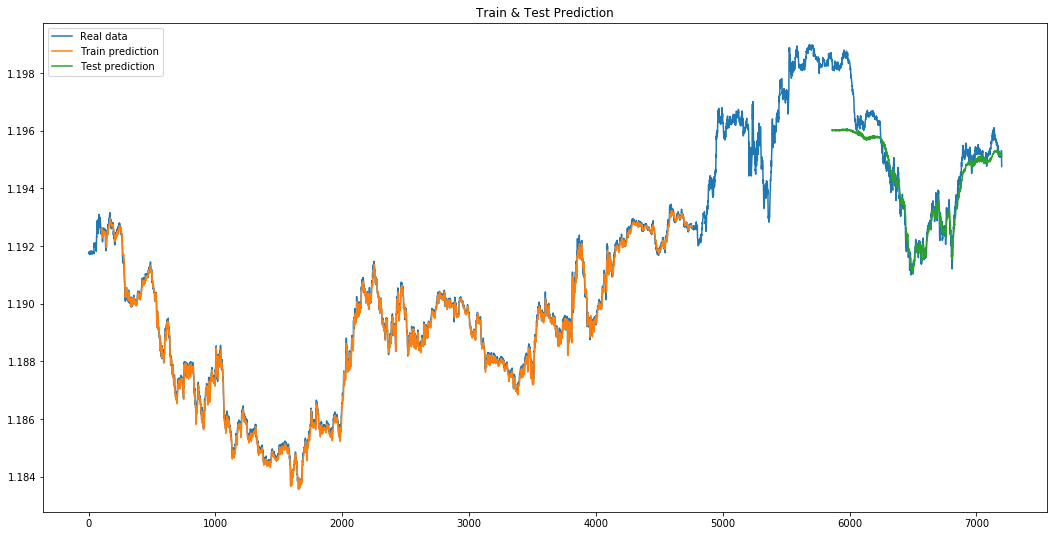

In [55]:
## Plotting 
# shift train predictions for plotting

plt.figure(figsize = (18,9))
#plt.xlim(6500,6560)
#plt.ylim(3.5, 6)

look_back=time_step
trainPredictPlot = numpy.empty_like(df)
trainPredictPlot[:,:]=np.nan

initialx_train=look_back
finalx_train=initialx_train+len(train_predict)

trainPredictPlot[initialx_train:finalx_train,:]=train_predict

# shift test predictions for plotting 
testPredictPlot = numpy.empty_like(df)
testPredictPlot[:,:]=numpy.nan

#initialx_test=finalx_train+(look_back)
initialx_test=len(train_data)+(look_back) 
finalx_test=initialx_test+len(test_predict)

testPredictPlot[initialx_test:finalx_test,:]=test_predict

plt.title('Train & Test Prediction')

# plot baseline and predictions 
plt.plot(df.values)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.legend(['Real data','Train prediction','Test prediction'], loc='upper left')


plt.show()

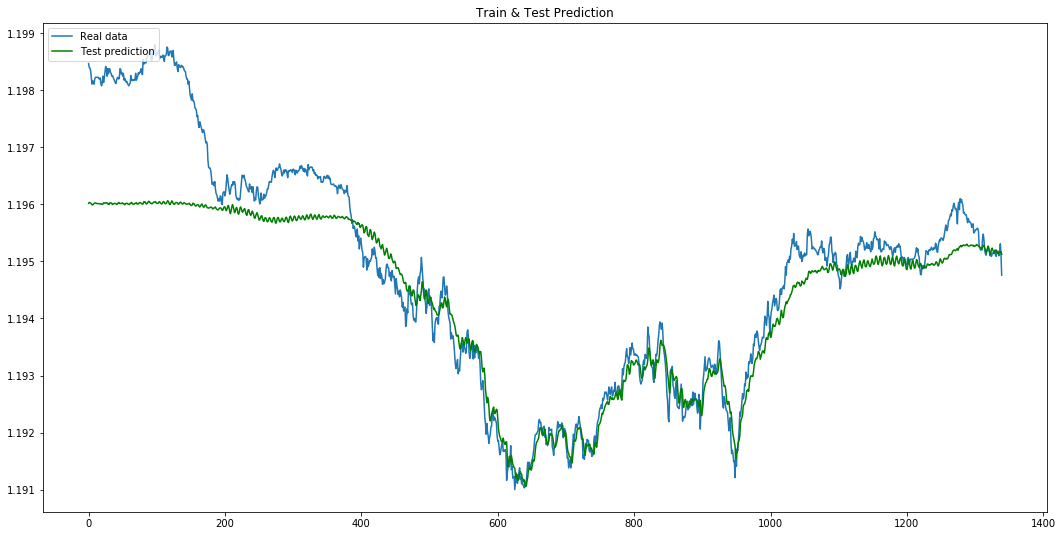

In [56]:
## Plotting 
# shift train predictions for plotting

plt.figure(figsize = (18,9))
#plt.xlim(6500,6560)
#plt.ylim(3.5, 6)

look_back=time_step
trainPredictPlot = numpy.empty_like(df)
trainPredictPlot[:,:]=np.nan

initialx_train=look_back
finalx_train=initialx_train+len(train_predict)

trainPredictPlot[initialx_train:finalx_train,:]=train_predict

# shift test predictions for plotting 
testPredictPlot = numpy.empty_like(df)
testPredictPlot[:,:]=numpy.nan

#initialx_test=finalx_train+(look_back)
initialx_test=len(train_data)+(look_back) 
finalx_test=initialx_test+len(test_predict)

testPredictPlot[initialx_test:finalx_test,:]=test_predict

plt.title('Train & Test Prediction')

# plot baseline and predictions 
plt.plot(y_test)
plt.plot(test_predict,color='green')
#plt.plot(testPredictPlot)
plt.legend(['Real data','Test prediction','Test prediction'], loc='upper left')


plt.show()

In [57]:
y_test

array([[1.19847],
       [1.1984 ],
       [1.19839],
       ...,
       [1.19531],
       [1.1951 ],
       [1.19476]])

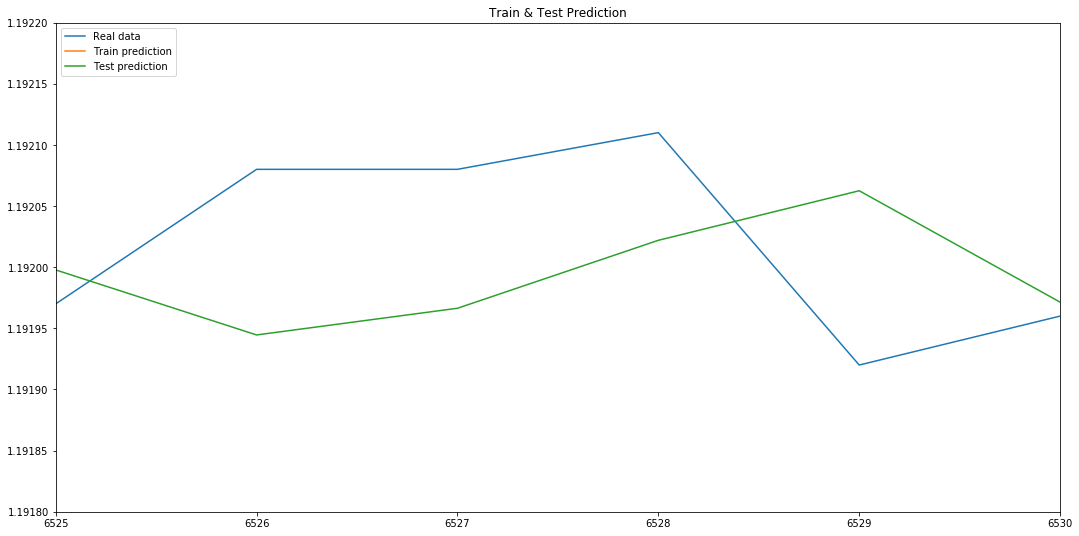

In [58]:
## Plotting 
# shift train predictions for plotting

plt.figure(figsize = (18,9))
plt.xlim(6525,6530)
plt.ylim(1.1918, 1.1922)## Plotting 
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = numpy.empty_like(df)
trainPredictPlot[:,:]=np.nan

initialx_train=look_back
finalx_train=initialx_train+len(train_predict)

trainPredictPlot[initialx_train:finalx_train,:]=train_predict

# shift test predictions for plotting 
testPredictPlot = numpy.empty_like(df)
testPredictPlot[:,:]=numpy.nan

#initialx_test=finalx_train+(look_back)
initialx_test=len(train_data)+(look_back) 
finalx_test=initialx_test+len(test_predict)

testPredictPlot[initialx_test:finalx_test,:]=test_predict

plt.title('Train & Test Prediction')

# plot baseline and predictions 
plt.plot(df.values)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.legend(['Real data','Train prediction','Test prediction'], loc='upper left')


plt.show()

In [59]:
def predictLSTM(n_days, predict_position, xAxix_zoomOut=0.001, yAxix_zoomOut=0.001):

    print("len(test_data): "+str(len(test_data)))

    # create x_input from test_data reshaped
    x_input=test_data[predict_position-time_step:predict_position].reshape(1,-1)
    print("x_input.shape: "+str(x_input.shape))

    # create temp_input from x_input
    temp_input=list(x_input)
    temp_input=temp_input[0].tolist()


    # demonstrate prediction for next 10 days
    from numpy import array

    lst_output=[]
    n_steps=100
    i=0
    while(i<n_days):

        if(len(temp_input)>time_step):
            x_input=np.array(temp_input[1:])
            x_input=x_input.reshape(1,-1)
            
            x_input = x_input.reshape((1, n_steps, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input=temp_input[1:]
            lst_output.extend(yhat.tolist())
            
            i=i+1
        else:
            x_input = x_input.reshape((1, n_steps,1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            
            i=i+1

    print("len(lst_output):"+str(len(lst_output)))
    
    day_new=np.arange(1,test_size)
    day_pred=np.arange((predict_position+1),(predict_position+1+n_days))

    print("len(df):"+str(len(df)))

    #plt.figure(figsize = (18,9))
    #plt.xlim(1325,1340)
    #plt.ylim(1.194, 1.196)
    
    xa,xb=(predict_position,predict_position+n_days)
    ya,yb=(min(test_data_unf[xa:xb].values),max(test_data_unf[xa:xb].values))
    plt.figure(figsize = (18,9))
    
    plt.xlim(xa*(1-xAxix_zoomOut),xb*(1+xAxix_zoomOut))
    plt.ylim(ya*(1-yAxix_zoomOut),yb*(1+yAxix_zoomOut))

    plt.plot(day_new,df[len(df)-len(day_new):len(df)],color='royalblue')
    plt.plot(day_pred,scaler.inverse_transform(lst_output),color='green')
    
    plt.legend(['Real data','Test prediction'], loc='upper left')
    

len(test_data): 1440
x_input.shape: (1, 100)
len(lst_output):30
len(df):7200


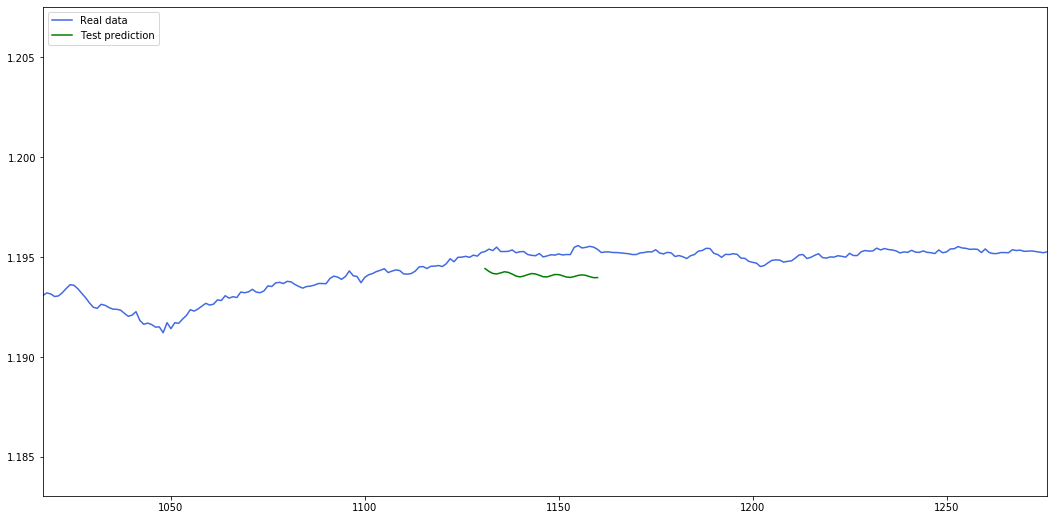

In [60]:
predictLSTM(30,1130, xAxix_zoomOut = 0.1, yAxix_zoomOut = 0.01) ##30 days prediction goes pretty well !!

len(test_data): 1440
x_input.shape: (1, 100)
len(lst_output):30
len(df):7200


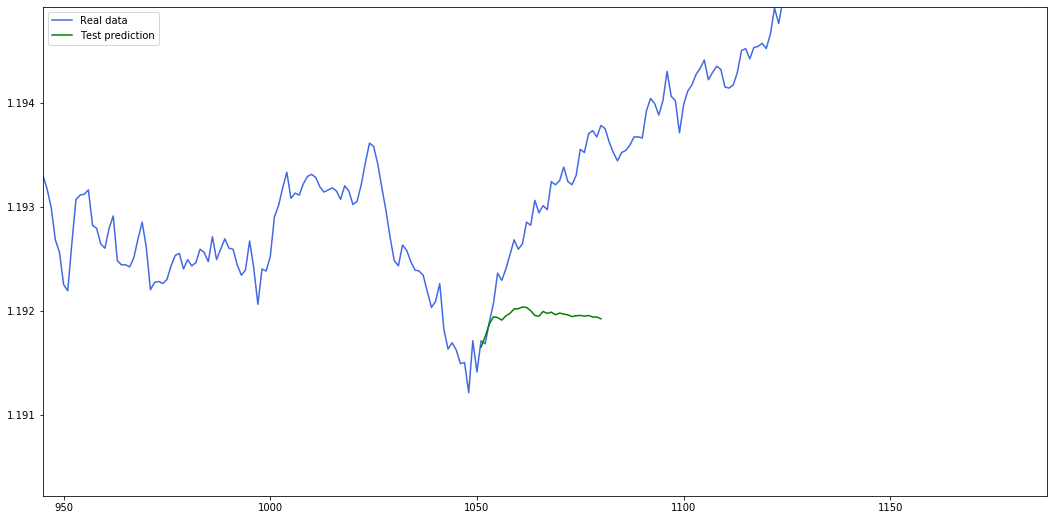

In [61]:
predictLSTM(30,1050, xAxix_zoomOut = 0.1, yAxix_zoomOut = 0.001) ##30 days prediction goes pretty well !!